In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [2]:
# Loading the dataset from the 'train' directory

batch_size = 512
seed = 1337 # Keep the seed same for both 'train' & 'validation' to avoid overlap

train_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train", 
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train",
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 120000 files belonging to 4 classes.
Using 96000 files for training.
Found 120000 files belonging to 4 classes.
Using 24000 files for validation.


In [3]:
from tensorflow.keras import layers

max_length = 50
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
# int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))



In [4]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [5]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [6]:
#setting compile and learning rate
adam = Adam(lr = 3e-4)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                73984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 5,194,244
Trainable params: 5,194,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="embeddings_bidir_gru.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [8]:
model_history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks_list)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_val_ds)[1]:.3f}")

Epoch 1/50
188/188 [==============================] - 179s 908ms/step - loss: 0.8918 - accuracy: 0.6777 - val_loss: 0.2711 - val_accuracy: 0.9127
Epoch 2/50
188/188 [==============================] - 114s 580ms/step - loss: 0.2461 - accuracy: 0.9251 - val_loss: 0.2615 - val_accuracy: 0.9139
Epoch 3/50
188/188 [==============================] - 125s 642ms/step - loss: 0.1798 - accuracy: 0.9459 - val_loss: 0.2851 - val_accuracy: 0.9080
Epoch 4/50
188/188 [==============================] - 133s 684ms/step - loss: 0.1413 - accuracy: 0.9565 - val_loss: 0.3238 - val_accuracy: 0.9046
Epoch 5/50
188/188 [==============================] - 140s 720ms/step - loss: 0.1147 - accuracy: 0.9637 - val_loss: 0.3460 - val_accuracy: 0.9045
Epoch 6/50
188/188 [==============================] - 150s 770ms/step - loss: 0.0905 - accuracy: 0.9720 - val_loss: 0.3725 - val_accuracy: 0.9010
Epoch 7/50
47/47 [==============================] - 8s 126ms/step - loss: 0.2615 - accuracy: 0.9139
Test acc: 0.914


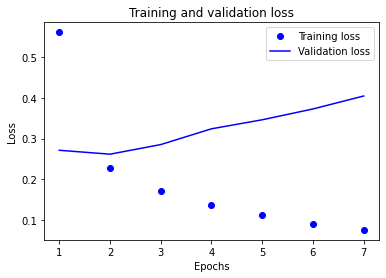

In [15]:
import matplotlib.pyplot as plt
#draw plot for visualization
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [10]:
# Using the trained model to make prediction on unseen (test) data
# Here we use the 'adapted' text_vectorization layer and include it as part of a prediction_model

prediction_model = tf.keras.Sequential(
    [text_vectorization, model])

prediction_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `val_ds`, which yields raw strings
loss, accuracy = prediction_model.evaluate(val_ds)
print("Accuracy: {:2.2%}".format(accuracy))

47/47 [==============================] - 9s 127ms/step - loss: 0.2581 - accuracy: 0.9138
Accuracy: 91.39%


In [11]:
# Read the test data in the form of a dataframe

df_test_data = pd.read_csv('../input/positionalembedding/data_test_df.csv')
inputs = df_test_data['data']

In [12]:
# Make sure you use the 'prediction_model' and not the trained 'model' alone
# If you use the 'model' object, you will run int error as the data is still in the 'text' format and needs vectorization

predicted_scores = prediction_model.predict(inputs)
predicted_scores[0:5]

array([[0.67010635, 0.04421223, 0.89687395, 0.6983654 ],
       [0.21802838, 0.17266199, 0.3858053 , 0.9733987 ],
       [0.19621412, 0.11547096, 0.5317757 , 0.9734986 ],
       [0.20860162, 0.20748696, 0.50508   , 0.93048376],
       [0.3417797 , 0.05519741, 0.4860074 , 0.9835112 ]], dtype=float32)

In [13]:
# populating the dataframe to make a submission on Kaggle

df_predictions = pd.DataFrame(predicted_scores, columns=['solution_' + str(i+1) for i in range(4)])
df_predictions.index.rename('Id', inplace=True)

df_predictions.head(30)

,solution_1,solution_2,solution_3,solution_4
Id,,,,
0,0.670106,0.044212,0.896874,0.698365
1,0.218028,0.172662,0.385805,0.973399
2,0.196214,0.115471,0.531776,0.973499
3,0.208602,0.207487,0.505080,0.930484
4,0.341780,0.055197,0.486007,0.983511
5,0.269258,0.128166,0.326748,0.978573
6,0.444506,0.083618,0.213552,0.983209
7,0.338614,0.230751,0.172769,0.969256
8,0.539342,0.055021,0.511406,0.957411


In [14]:
# If using colab, then download this and submit on Kaggle

df_predictions.to_csv('df_predictions_10.csv')